## Chapter 10: Multi-Layer Perceptrons with Keras

Now that I've got [Tensorflow on this machine that doesn't have AVX support](https://www.eggwall.com/2020/09/compiling-tensorflow-without-avx.html), let's take it for a ride.


In [49]:
# Common imports

import matplotlib.cm as cm
from matplotlib.image import imread
# import matplotlib as mpl
import matplotlib.pyplot as plt
# import mpl_toolkits.mplot3d.axes3d as p3

import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score

from sklearn.datasets import fetch_california_housing
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras

print("TF version ", tf.__version__)
print("Keras version ", keras.__version__)

TF version  2.3.0
Keras version  2.4.0


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
print (X_train_full.shape)
print (X_train_full.dtype)

4423680/4422102 [==============================] - 6s 1us/step
(60000, 28, 28)
uint8


In [3]:
print (X_train_full.shape)
print (X_train_full.dtype)

(60000, 28, 28)
uint8


Let's split this into a validation set. First 5000 are kept aside for validation.

Pixel densities in the attributes are 0-255, so scaling them down to \[0,1\].
Notice how we specify 255.0 otherwise integer division will lead to either 0 or 1.

In [5]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000]        , y_train_full[5000:]
X_test = X_test / 255.0

These class-names are specified on the [Keras website](https://www.tensorflow.org/tutorials/keras/classification)

In [11]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [12]:
class_names[y_train[0]]

'Coat'

Let's look at a single image. By now I am good enough to print this stuff out.

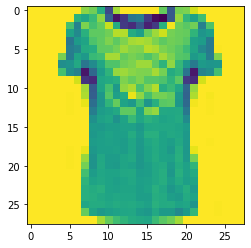

In [15]:
plt.imshow(1 - X_train[1])

And let's create a Tensorflow network with Keras.

In [17]:
# model = keras.models.Sequential()
# model.add(keras.layers.Flatten(input_shape=[28, 28]))
# model.add(keras.layers.Dense(300, activation="relu"))
# model.add(keras.layers.Dense(100, activation="relu"))
# model.add(keras.layers.Dense(10, activation="softmax"))

# This is another way of creating it:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.layers

In [20]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

In [21]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 39s 23ms/step - loss: 0.7015 - accuracy: 0.7694 - val_loss: 0.5748 - val_accuracy: 0.7924
Epoch 2/30
1719/1719 [==============================] - 39s 23ms/step - loss: 0.4864 - accuracy: 0.8314 - val_loss: 0.4725 - val_accuracy: 0.8358
Epoch 3/30
1719/1719 [==============================] - 39s 23ms/step - loss: 0.4426 - accuracy: 0.8451 - val_loss: 0.4166 - val_accuracy: 0.8580
Epoch 4/30
1719/1719 [==============================] - 39s 23ms/step - loss: 0.4159 - accuracy: 0.8528 - val_loss: 0.4072 - val_accuracy: 0.8622
Epoch 5/30
1719/1719 [==============================] - 39s 23ms/step - loss: 0.3955 - accuracy: 0.8620 - val_loss: 0.3893 - val_accuracy: 0.8636
Epoch 6/30
1719/1719 [==============================] - 39s 23ms/step - loss: 0.3798 - accuracy: 0.8653 - val_loss: 0.3668 - val_accuracy: 0.8718
Epoch 7/30
1719/1719 [==============================] - 39s 23ms/step - loss: 0.3651 - accuracy: 0.8707 - val_loss: 0.3612 -

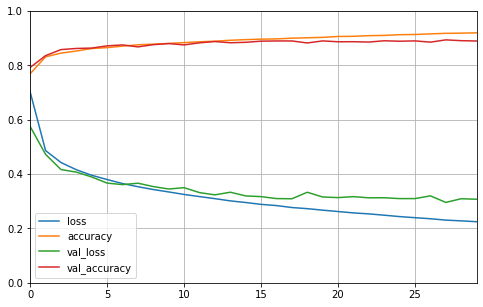

In [22]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()

This looks good, and convergence has been reached. Accuracy is close to validation accuracy.

In [30]:
# The same model as earlier, but with a different learning rate.
model_lr = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

# Got a learning rate example from here: https://keras.io/api/optimizers/
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

model_lr.compile(loss="sparse_categorical_crossentropy",
                 optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
                 metrics=["accuracy"])
history_lr = model_lr.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 40s 24ms/step - loss: 0.7146 - accuracy: 0.7642 - val_loss: 0.5144 - val_accuracy: 0.8260
Epoch 2/30
1719/1719 [==============================] - 41s 24ms/step - loss: 0.4927 - accuracy: 0.8298 - val_loss: 0.4485 - val_accuracy: 0.8474
Epoch 3/30
1719/1719 [==============================] - 41s 24ms/step - loss: 0.4444 - accuracy: 0.8449 - val_loss: 0.4138 - val_accuracy: 0.8596
Epoch 4/30
1719/1719 [==============================] - 42s 24ms/step - loss: 0.4185 - accuracy: 0.8537 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 5/30
1719/1719 [==============================] - 41s 24ms/step - loss: 0.3991 - accuracy: 0.8613 - val_loss: 0.4304 - val_accuracy: 0.8504
Epoch 6/30
1719/1719 [==============================] - 41s 24ms/step - loss: 0.3821 - accuracy: 0.8669 - val_loss: 0.3776 - val_accuracy: 0.8662
Epoch 7/30
1719/1719 [==============================] - 41s 24ms/step - loss: 0.3694 - accuracy: 0.8703 - val_loss: 0.3685 -

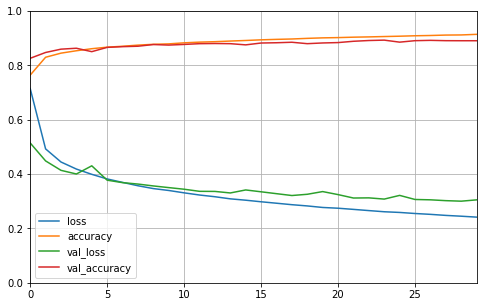

In [35]:
import pandas as pd

pd.DataFrame(history_lr.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()

# Batch processing, for later

For later, run with many more epochs and see if the performance improves considerably

In [31]:
# The same model as earlier, but with many more epochs than earlier.
model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model2.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])
history2 = model2.fit(X_train, y_train, epochs=300,
                   validation_data=(X_valid, y_valid))

Epoch 1/300
1719/1719 [==============================] - 43s 25ms/step - loss: 0.7163 - accuracy: 0.7680 - val_loss: 0.5420 - val_accuracy: 0.8142
Epoch 2/300
1719/1719 [==============================] - 42s 25ms/step - loss: 0.4888 - accuracy: 0.8305 - val_loss: 0.4649 - val_accuracy: 0.8332
Epoch 3/300
1719/1719 [==============================] - 43s 25ms/step - loss: 0.4449 - accuracy: 0.8432 - val_loss: 0.4219 - val_accuracy: 0.8536
Epoch 4/300
1719/1719 [==============================] - 42s 25ms/step - loss: 0.4173 - accuracy: 0.8546 - val_loss: 0.4026 - val_accuracy: 0.8648
Epoch 5/300
1719/1719 [==============================] - 43s 25ms/step - loss: 0.3968 - accuracy: 0.8616 - val_loss: 0.3969 - val_accuracy: 0.8602
Epoch 6/300
1719/1719 [==============================] - 42s 25ms/step - loss: 0.3804 - accuracy: 0.8665 - val_loss: 0.3721 - val_accuracy: 0.8690
Epoch 7/300
1719/1719 [==============================] - 43s 25ms/step - loss: 0.3669 - accuracy: 0.8700 - val_loss: 0

1719/1719 [==============================] - 42s 24ms/step - loss: 0.0581 - accuracy: 0.9811 - val_loss: 0.3833 - val_accuracy: 0.8912
Epoch 115/300
1719/1719 [==============================] - 42s 24ms/step - loss: 0.0586 - accuracy: 0.9809 - val_loss: 0.3756 - val_accuracy: 0.8992
Epoch 116/300
1719/1719 [==============================] - 42s 24ms/step - loss: 0.0569 - accuracy: 0.9814 - val_loss: 0.3876 - val_accuracy: 0.8946
Epoch 117/300
1719/1719 [==============================] - 42s 25ms/step - loss: 0.0548 - accuracy: 0.9820 - val_loss: 0.3898 - val_accuracy: 0.8978
Epoch 118/300
1719/1719 [==============================] - 42s 24ms/step - loss: 0.0553 - accuracy: 0.9819 - val_loss: 0.4048 - val_accuracy: 0.8928
Epoch 119/300
1719/1719 [==============================] - 42s 24ms/step - loss: 0.0550 - accuracy: 0.9823 - val_loss: 0.3868 - val_accuracy: 0.8956
Epoch 120/300
1719/1719 [==============================] - 42s 25ms/step - loss: 0.0530 - accuracy: 0.9831 - val_loss: 0

1719/1719 [==============================] - 42s 24ms/step - loss: 0.0194 - accuracy: 0.9947 - val_loss: 0.5086 - val_accuracy: 0.8944
Epoch 170/300
1719/1719 [==============================] - 42s 25ms/step - loss: 0.0198 - accuracy: 0.9947 - val_loss: 0.4802 - val_accuracy: 0.8952
Epoch 171/300
1719/1719 [==============================] - 42s 24ms/step - loss: 0.0186 - accuracy: 0.9952 - val_loss: 0.5070 - val_accuracy: 0.8930
Epoch 172/300
1719/1719 [==============================] - 42s 25ms/step - loss: 0.0197 - accuracy: 0.9946 - val_loss: 0.4925 - val_accuracy: 0.8972
Epoch 173/300
1719/1719 [==============================] - 42s 25ms/step - loss: 0.0165 - accuracy: 0.9962 - val_loss: 0.5092 - val_accuracy: 0.8954
Epoch 174/300
1719/1719 [==============================] - 42s 24ms/step - loss: 0.0161 - accuracy: 0.9960 - val_loss: 0.4912 - val_accuracy: 0.8974
Epoch 175/300
1719/1719 [==============================] - 42s 25ms/step - loss: 0.0167 - accuracy: 0.9960 - val_loss: 0

1719/1719 [==============================] - 42s 24ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.5731 - val_accuracy: 0.8974
Epoch 225/300
1719/1719 [==============================] - 42s 25ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.5663 - val_accuracy: 0.8988
Epoch 226/300
1719/1719 [==============================] - 42s 24ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.5693 - val_accuracy: 0.8986
Epoch 227/300
1719/1719 [==============================] - 42s 24ms/step - loss: 0.0027 - accuracy: 0.9999 - val_loss: 0.5749 - val_accuracy: 0.8982
Epoch 228/300
1719/1719 [==============================] - 42s 24ms/step - loss: 0.0027 - accuracy: 0.9999 - val_loss: 0.5774 - val_accuracy: 0.8980
Epoch 229/300
1719/1719 [==============================] - 42s 24ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.5684 - val_accuracy: 0.8974
Epoch 230/300
1719/1719 [==============================] - 42s 25ms/step - loss: 0.0026 - accuracy: 0.9999 - val_loss: 0

1719/1719 [==============================] - 42s 25ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.6195 - val_accuracy: 0.8988
Epoch 280/300
1719/1719 [==============================] - 42s 24ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.6193 - val_accuracy: 0.8984
Epoch 281/300
1719/1719 [==============================] - 42s 24ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.6211 - val_accuracy: 0.8984
Epoch 282/300
1719/1719 [==============================] - 42s 24ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.6214 - val_accuracy: 0.8980
Epoch 283/300
1719/1719 [==============================] - 42s 24ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.6219 - val_accuracy: 0.8980
Epoch 284/300
1719/1719 [==============================] - 42s 25ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.6246 - val_accuracy: 0.8980
Epoch 285/300
1719/1719 [==============================] - 42s 24ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0

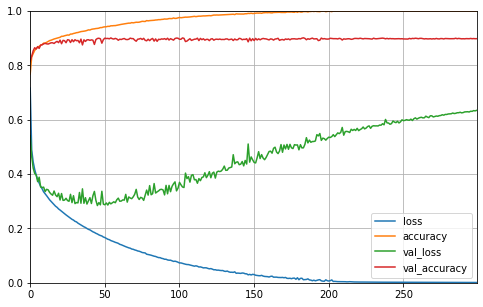

In [36]:
import pandas as pd

pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()

This looks overfitted. The accuracy is 100% but the validation accuracy is 91%.

In [32]:
# A deeper model than earlier, but with as many epochs as the first.
model3 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model3.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])
history3 = model3.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 60s 35ms/step - loss: 0.7099 - accuracy: 0.7638 - val_loss: 0.4921 - val_accuracy: 0.8350
Epoch 2/30
1719/1719 [==============================] - 60s 35ms/step - loss: 0.4708 - accuracy: 0.8358 - val_loss: 0.4589 - val_accuracy: 0.8362
Epoch 3/30
1719/1719 [==============================] - 60s 35ms/step - loss: 0.4236 - accuracy: 0.8506 - val_loss: 0.3978 - val_accuracy: 0.8662
Epoch 4/30
1719/1719 [==============================] - 60s 35ms/step - loss: 0.3954 - accuracy: 0.8593 - val_loss: 0.3922 - val_accuracy: 0.8592
Epoch 5/30
1719/1719 [==============================] - 60s 35ms/step - loss: 0.3751 - accuracy: 0.8652 - val_loss: 0.3676 - val_accuracy: 0.8742
Epoch 6/30
1719/1719 [==============================] - 60s 35ms/step - loss: 0.3585 - accuracy: 0.8711 - val_loss: 0.3486 - val_accuracy: 0.8776
Epoch 7/30
1719/1719 [==============================] - 59s 35ms/step - loss: 0.3449 - accuracy: 0.8756 - val_loss: 0.3486 -

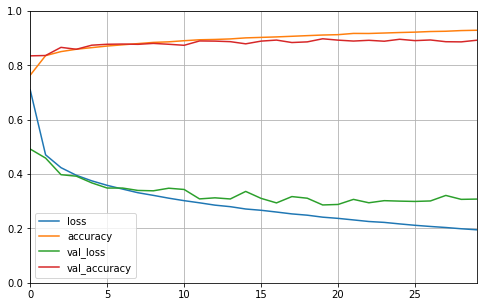

In [38]:
import pandas as pd

pd.DataFrame(history3.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()

This looks good, and convergence has been reached. Accuracy is close to validation accuracy.

In [33]:
# A deeper model than earlier, but constraining the input layer and expanding again
model4 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model4.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])
history4 = model4.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 42s 24ms/step - loss: 0.7988 - accuracy: 0.7269 - val_loss: 0.5158 - val_accuracy: 0.8262
Epoch 2/30
1719/1719 [==============================] - 41s 24ms/step - loss: 0.4945 - accuracy: 0.8251 - val_loss: 0.4614 - val_accuracy: 0.8420
Epoch 3/30
1719/1719 [==============================] - 41s 24ms/step - loss: 0.4401 - accuracy: 0.8448 - val_loss: 0.4393 - val_accuracy: 0.8462
Epoch 4/30
1719/1719 [==============================] - 42s 24ms/step - loss: 0.4095 - accuracy: 0.8534 - val_loss: 0.3902 - val_accuracy: 0.8648
Epoch 5/30
1719/1719 [==============================] - 41s 24ms/step - loss: 0.3856 - accuracy: 0.8620 - val_loss: 0.3803 - val_accuracy: 0.8630
Epoch 6/30
1719/1719 [==============================] - 42s 24ms/step - loss: 0.3684 - accuracy: 0.8676 - val_loss: 0.3617 - val_accuracy: 0.8744
Epoch 7/30
1719/1719 [==============================] - 42s 24ms/step - loss: 0.3523 - accuracy: 0.8727 - val_loss: 0.3745 -

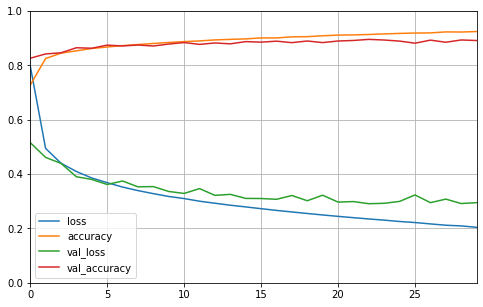

In [37]:
import pandas as pd

pd.DataFrame(history4.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()

This looks good, and convergence has been reached. Accuracy is close to validation accuracy.

In [34]:
model4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_20 (Dense)             (None, 50)                15050     
_________________________________________________________________
dense_21 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_22 (Dense)             (None, 10)                1010      
Total params: 256,660
Trainable params: 256,660
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# The same model as earlier, but with many more epochs than earlier.
model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model2.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])
history2 = model2.fit(X_train, y_train, epochs=300,
                   validation_data=(X_valid, y_valid))

Epoch 1/300
1719/1719 [==============================] - 33s 19ms/step - loss: 0.7084 - accuracy: 0.7669 - val_loss: 0.5026 - val_accuracy: 0.8300
Epoch 2/300
1719/1719 [==============================] - 33s 19ms/step - loss: 0.4839 - accuracy: 0.8321 - val_loss: 0.4500 - val_accuracy: 0.8406
Epoch 3/300
1719/1719 [==============================] - 33s 19ms/step - loss: 0.4399 - accuracy: 0.8459 - val_loss: 0.4070 - val_accuracy: 0.8634
Epoch 4/300
1719/1719 [==============================] - 33s 19ms/step - loss: 0.4128 - accuracy: 0.8542 - val_loss: 0.3862 - val_accuracy: 0.8682
Epoch 5/300
1719/1719 [==============================] - 33s 19ms/step - loss: 0.3939 - accuracy: 0.8612 - val_loss: 0.3728 - val_accuracy: 0.8722
Epoch 6/300
1719/1719 [==============================] - 33s 19ms/step - loss: 0.3782 - accuracy: 0.8678 - val_loss: 0.3715 - val_accuracy: 0.8708
Epoch 7/300
1719/1719 [==============================] - 33s 19ms/step - loss: 0.3648 - accuracy: 0.8711 - val_loss: 0

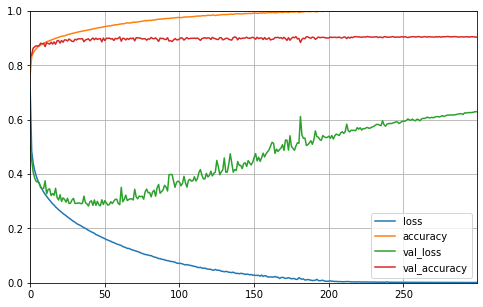

In [40]:
import pandas as pd

pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()

This looks overfitted. The accuracy is 100% but the validation accuracy is 91%.

Let's make a very deep model and see if that is better than model4, from which this is copied.

In [41]:
# A deeper model than earlier, but constraining the input layer and expanding again
model4_deep = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model4_deep.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])
history4_deep = model4_deep.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 45s 26ms/step - loss: 0.9027 - accuracy: 0.6771 - val_loss: 0.5056 - val_accuracy: 0.8268
Epoch 2/30
1719/1719 [==============================] - 45s 26ms/step - loss: 0.4989 - accuracy: 0.8227 - val_loss: 0.4496 - val_accuracy: 0.8442
Epoch 3/30
1719/1719 [==============================] - 45s 26ms/step - loss: 0.4333 - accuracy: 0.8442 - val_loss: 0.4210 - val_accuracy: 0.8448
Epoch 4/30
1719/1719 [==============================] - 45s 26ms/step - loss: 0.3961 - accuracy: 0.8558 - val_loss: 0.4251 - val_accuracy: 0.8400
Epoch 5/30
1719/1719 [==============================] - 45s 26ms/step - loss: 0.3704 - accuracy: 0.8645 - val_loss: 0.3599 - val_accuracy: 0.8722
Epoch 6/30
1719/1719 [==============================] - 45s 26ms/step - loss: 0.3510 - accuracy: 0.8708 - val_loss: 0.3363 - val_accuracy: 0.8832
Epoch 7/30
1719/1719 [==============================] - 45s 26ms/step - loss: 0.3335 - accuracy: 0.8776 - val_loss: 0.3296 -

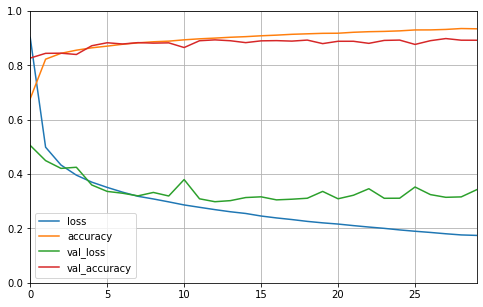

In [42]:
import pandas as pd

pd.DataFrame(history4_deep.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()

So adding extra layers didn't do much good. Let's try removing layers to see what we get.

In [45]:
# A deeper model than earlier, but constraining the input layer and expanding again
model4_shallow = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model4_shallow.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])
history4_shallow = model4_shallow.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 34s 20ms/step - loss: 0.7180 - accuracy: 0.7634 - val_loss: 0.4988 - val_accuracy: 0.8334
Epoch 2/30
1719/1719 [==============================] - 33s 19ms/step - loss: 0.4895 - accuracy: 0.8298 - val_loss: 0.4509 - val_accuracy: 0.8438
Epoch 3/30
1719/1719 [==============================] - 33s 19ms/step - loss: 0.4425 - accuracy: 0.8449 - val_loss: 0.4376 - val_accuracy: 0.8454
Epoch 4/30
1719/1719 [==============================] - 33s 19ms/step - loss: 0.4148 - accuracy: 0.8540 - val_loss: 0.4436 - val_accuracy: 0.8398
Epoch 5/30
1719/1719 [==============================] - 33s 19ms/step - loss: 0.3944 - accuracy: 0.8611 - val_loss: 0.4088 - val_accuracy: 0.8522
Epoch 6/30
1719/1719 [==============================] - 37s 22ms/step - loss: 0.3787 - accuracy: 0.8669 - val_loss: 0.3887 - val_accuracy: 0.8640
Epoch 7/30
1719/1719 [==============================] - 37s 21ms/step - loss: 0.3652 - accuracy: 0.8714 - val_loss: 0.3592 -

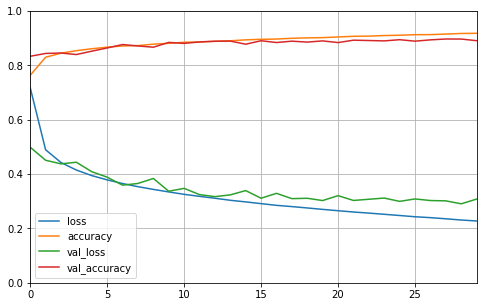

In [46]:
import pandas as pd

pd.DataFrame(history4_shallow.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Y axis set to [0,1]
plt.show()

In [64]:
import pydot
keras.utils.plot_model(model4_shallow, to_file='model.png',
                       show_shapes=False, show_layer_names=True,
                       rankdir='TB', expand_nested=False, dpi=96)



('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


This is how you save a model to disk for reading later. This avoids the incredibly costly model training process.

In [65]:
model4.save('saved_models/fashion_model4')

INFO:tensorflow:Assets written to: saved_models/fashion_model4/assets


INFO:tensorflow:Assets written to: saved_models/fashion_model4/assets


This is how you load a previously-saved model from disk.

In [68]:
new_model4 = keras.models.load_model('saved_models/fashion_model4')


Let's try converting these to Tensorflow Lite. The book does not cover it, but could we use this model on an edge TPU device?

In [47]:
converter = tf.lite.TFLiteConverter.from_keras_model(model4_shallow)
tflite_model = converter.convert()


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmprp6ctj8a/assets


In [48]:
tflite_model

b'\x1c\x00\x00\x00TFL3\x00\x00\x12\x00\x1c\x00\x04\x00\x08\x00\x0c\x00\x10\x00\x14\x00\x00\x00\x18\x00\x12\x00\x00\x00\x03\x00\x00\x00\x14\x00\x00\x00 \x00\x00\x00\xb4\x00\x00\x00 \x00\x00\x00\\\x00\x00\x00\x03\x00\x00\x00\x1c\x04\x00\x00`\x03\x00\x00t\x01\x00\x00\x01\x00\x00\x00\xb8\x00\x00\x00\x0f\x00\x00\x00\\M\x10\x00XM\x10\x00\xc0G\x10\x00\xb8E\x10\x00$E\x10\x00\xb4D\x10\x00\\\xe9\x01\x00D\x14\x00\x00L\x04\x00\x008M\x10\x004M\x10\x000M\x10\x00,M\x10\x00(M\x10\x008\x00\x00\x00\x01\x00\x00\x00\x0c\x00\x00\x00\x08\x00\x0c\x00\x04\x00\x08\x00\x08\x00\x00\x00\x08\x00\x00\x00\x0e\x00\x00\x00\x13\x00\x00\x00min_runtime_version\x00\xae\xb8\xef\xff\x04\x00\x00\x00\x10\x00\x00\x001.5.0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0f\x00\x00\x00MLIR Converted.\x00\x00\x00\x0e\x00\x18\x00\x04\x00\x08\x00\x0c\x00\x10\x00\x14\x00\x0e\x00\x00\x00\x14\x00\x00\x00H\x00\x00\x00L\x00\x00\x00P\x00\x00\x00d\x00\x00\x00\r\x00\x00\x008L\x10\x00\xc4K\x10\x00\x8cF\x10\x00\x90D\x10\x00\x10D\x10\x00\xa0C\x1

Ok, that was easy, but now I need an edge TPU board to load that model and make sure it actually does something.

The way to load this is to use tflite, but I need to try that out on a board.

# Regression MLP using the Sequential API

You can use NNs for regression as well. The output is ordinal, and trained on ordinal data.

In [19]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
                                                housing.data, housing.target)


X_train, X_valid, y_train, y_valid = train_test_split(
                                                X_train_full, y_train_full)

scaler = StandardScaler()


In [20]:
X_train = scaler.fit_transform(X_train)
# Always use the same scaler for the X_validation and X_test!
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [21]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20,
                   validation_data = (X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)



Epoch 1/20
363/363 [==============================] - 1s 3ms/step - loss: 0.8730 - val_loss: 21.6518
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9217 - val_loss: 7.2756
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4321 - val_loss: 35.0466
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4935 - val_loss: 91.2110
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5430 - val_loss: 0.3798
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3949 - val_loss: 0.3537
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3831 - val_loss: 0.3454
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3760 - val_loss: 0.3403
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3702 - val_loss: 0.3351
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3664 - val_loss: 0.3

# Fine-Tuning Neural Network Hyperparameters

Seems like it is difficult to tell how many layers, how many neurons, and the learning rate, so you use GridSearch on it.  Here's how for the previous example


In [22]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    "Create a model with paramters specified"
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="selu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [96]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

You can train a model using keras_reg as a model.

In [ ]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks = [keras.callbacks.EarlyStopping(patience=10)],
              verbose = 0) # Don't tell me about every epoch

mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)

Or, you can train a very computationally intensive Randomized or GridSearch here. I don't fully understand why Randomized Search is better here, but let's listen to the book and try it anyway

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime

param_distribs = {
    "n_hidden": [0, 1, 2, 3, 4, 5, 6, 7, 8],
    "n_neurons": np.arange(1, 200),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

start_time = datetime.now()
# The best estimator is only available if we 'refit=True'
rnd_cv = RandomizedSearchCV(keras_reg, param_distribs,
                            n_iter=10, cv=3, refit=True)

rnd_cv.fit(X_train, y_train, epochs=200,
           validation_data=(X_valid, y_valid),
           callbacks=[keras.callbacks.EarlyStopping(patience=10)],
           verbose=0) # Don't be too verbose

end_time = datetime.now()


Epoch 1/200
242/242 [==============================] - 1s 5ms/step - loss: 2.8734 - val_loss: 1.3440
Epoch 2/200
242/242 [==============================] - 1s 4ms/step - loss: 0.9552 - val_loss: 0.6899
Epoch 3/200
242/242 [==============================] - 1s 4ms/step - loss: 0.6490 - val_loss: 0.6035
Epoch 4/200
242/242 [==============================] - 1s 4ms/step - loss: 0.5985 - val_loss: 0.5837
Epoch 5/200
242/242 [==============================] - 1s 4ms/step - loss: 0.5811 - val_loss: 0.5717
Epoch 6/200
242/242 [==============================] - 1s 4ms/step - loss: 0.5694 - val_loss: 0.5611
Epoch 7/200
242/242 [==============================] - 1s 4ms/step - loss: 0.5602 - val_loss: 0.5533
Epoch 8/200
242/242 [==============================] - 1s 4ms/step - loss: 0.5528 - val_loss: 0.5454
Epoch 9/200
242/242 [==============================] - 1s 4ms/step - loss: 0.5464 - val_loss: 0.5388
Epoch 10/200
242/242 [==============================] - 1s 4ms/step - loss: 0.5409 - val_lo

Epoch 161/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4544 - val_loss: 0.4510
Epoch 162/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4542 - val_loss: 0.4512
Epoch 163/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4538 - val_loss: 0.4509
Epoch 164/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4537 - val_loss: 0.4505
Epoch 165/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4532 - val_loss: 0.4503
Epoch 166/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4532 - val_loss: 0.4502
Epoch 167/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4529 - val_loss: 0.4503
Epoch 168/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4528 - val_loss: 0.4500
Epoch 169/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4524 - val_loss: 0.4495
Epoch 170/200
242/242 [==============================] - 1s 4ms/step - lo

242/242 [==============================] - 1s 4ms/step - loss: 0.4645 - val_loss: 0.4658
Epoch 121/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4642 - val_loss: 0.4653
Epoch 122/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4640 - val_loss: 0.4652
Epoch 123/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4636 - val_loss: 0.4648
Epoch 124/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4634 - val_loss: 0.4648
Epoch 125/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4632 - val_loss: 0.4647
Epoch 126/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4630 - val_loss: 0.4643
Epoch 127/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4627 - val_loss: 0.4643
Epoch 128/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4624 - val_loss: 0.4639
Epoch 129/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4622 - v

Epoch 79/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4750 - val_loss: 0.4729
Epoch 80/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4749 - val_loss: 0.4732
Epoch 81/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4745 - val_loss: 0.4729
Epoch 82/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4742 - val_loss: 0.4726
Epoch 83/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4739 - val_loss: 0.4721
Epoch 84/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4734 - val_loss: 0.4723
Epoch 85/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4732 - val_loss: 0.4719
Epoch 86/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4728 - val_loss: 0.4711
Epoch 87/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4726 - val_loss: 0.4711
Epoch 88/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4724

242/242 [==============================] - 1s 4ms/step - loss: 0.4729 - val_loss: 0.4636
Epoch 38/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4710 - val_loss: 0.4616
Epoch 39/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4691 - val_loss: 0.4599
Epoch 40/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4670 - val_loss: 0.4588
Epoch 41/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4656 - val_loss: 0.4566
Epoch 42/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4635 - val_loss: 0.4553
Epoch 43/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4620 - val_loss: 0.4538
Epoch 44/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4600 - val_loss: 0.4530
Epoch 45/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4586 - val_loss: 0.4510
Epoch 46/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4569 - val_loss: 

242/242 [==============================] - 1s 4ms/step - loss: 0.3692 - val_loss: 0.3831
Epoch 197/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3691 - val_loss: 0.3832
Epoch 198/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3686 - val_loss: 0.3843
Epoch 199/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3686 - val_loss: 0.3836
Epoch 200/200
121/121 [==============================] - 0s 2ms/step - loss: 0.3761
Epoch 1/200
242/242 [==============================] - 1s 4ms/step - loss: 2.1398 - val_loss: 0.8318
Epoch 2/200
242/242 [==============================] - 1s 4ms/step - loss: 0.7184 - val_loss: 0.6640
Epoch 3/200
242/242 [==============================] - 1s 4ms/step - loss: 0.6354 - val_loss: 0.6137
Epoch 4/200
242/242 [==============================] - 1s 4ms/step - loss: 0.5956 - val_loss: 0.5816
Epoch 5/200
242/242 [==============================] - 1s 4ms/step - loss: 0.5683 - val_loss: 0.5593
Epoch 6/200
2

Epoch 76/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4070 - val_loss: 0.4201
Epoch 77/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4067 - val_loss: 0.4186
Epoch 78/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4056 - val_loss: 0.4191
Epoch 79/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4052 - val_loss: 0.4192
Epoch 80/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4047 - val_loss: 0.4173
Epoch 81/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4039 - val_loss: 0.4176
Epoch 82/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4035 - val_loss: 0.4163
Epoch 83/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4031 - val_loss: 0.4182
Epoch 84/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4027 - val_loss: 0.4161
Epoch 85/200
242/242 [==============================] - 1s 4ms/step - loss: 0.4012

Epoch 156/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3774 - val_loss: 0.4017
Epoch 157/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3774 - val_loss: 0.4013
Epoch 158/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3767 - val_loss: 0.4018
Epoch 159/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3770 - val_loss: 0.4009
Epoch 160/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3763 - val_loss: 0.4005
Epoch 161/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3762 - val_loss: 0.4017
Epoch 162/200
242/242 [==============================] - 1s 3ms/step - loss: 0.3762 - val_loss: 0.4005
Epoch 163/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3759 - val_loss: 0.4010
Epoch 164/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3755 - val_loss: 0.3997
Epoch 165/200
242/242 [==============================] - 1s 4ms/step - lo

242/242 [==============================] - 1s 4ms/step - loss: 0.3876 - val_loss: 0.4114
Epoch 116/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3867 - val_loss: 0.4095
Epoch 117/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3867 - val_loss: 0.4088
Epoch 118/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3860 - val_loss: 0.4082
Epoch 119/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3858 - val_loss: 0.4078
Epoch 120/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3856 - val_loss: 0.4076
Epoch 121/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3848 - val_loss: 0.4091
Epoch 122/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3840 - val_loss: 0.4111
Epoch 123/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3845 - val_loss: 0.4067
Epoch 124/200
242/242 [==============================] - 1s 4ms/step - loss: 0.3839 - v

242/242 [==============================] - 4s 17ms/step - loss: 0.2923 - val_loss: 0.3018
Epoch 39/200
242/242 [==============================] - 4s 17ms/step - loss: 0.2891 - val_loss: 0.3077
Epoch 40/200
242/242 [==============================] - 4s 17ms/step - loss: 0.2876 - val_loss: 0.3344
Epoch 41/200
242/242 [==============================] - 4s 17ms/step - loss: 0.2837 - val_loss: 0.3209
Epoch 42/200
242/242 [==============================] - 4s 17ms/step - loss: 0.2848 - val_loss: 0.3180
Epoch 43/200
242/242 [==============================] - 4s 17ms/step - loss: 0.2866 - val_loss: 0.2915
Epoch 44/200
242/242 [==============================] - 4s 17ms/step - loss: 0.2848 - val_loss: 0.3212
Epoch 45/200
242/242 [==============================] - 4s 17ms/step - loss: 0.2802 - val_loss: 0.2991
Epoch 46/200
242/242 [==============================] - 4s 17ms/step - loss: 0.2835 - val_loss: 0.3248
Epoch 47/200
242/242 [==============================] - 4s 17ms/step - loss: 0.2787 - 

242/242 [==============================] - 3s 12ms/step - loss: 0.3296 - val_loss: 0.3334
Epoch 16/200
242/242 [==============================] - 3s 12ms/step - loss: 0.3327 - val_loss: 0.3892
Epoch 17/200
242/242 [==============================] - 3s 11ms/step - loss: 0.3266 - val_loss: 0.3304
Epoch 18/200
242/242 [==============================] - 3s 12ms/step - loss: 0.3260 - val_loss: 0.3139
Epoch 19/200
242/242 [==============================] - 3s 12ms/step - loss: 0.3271 - val_loss: 0.3394
Epoch 20/200
242/242 [==============================] - 3s 12ms/step - loss: 0.3171 - val_loss: 0.3289
Epoch 21/200
242/242 [==============================] - 3s 12ms/step - loss: 0.3599 - val_loss: 0.3253
Epoch 22/200
242/242 [==============================] - 3s 12ms/step - loss: 0.3257 - val_loss: 0.4650
Epoch 23/200
242/242 [==============================] - 3s 12ms/step - loss: 0.3267 - val_loss: 0.3373
Epoch 24/200
242/242 [==============================] - 3s 12ms/step - loss: 0.3127 - 

242/242 [==============================] - 4s 16ms/step - loss: 0.3556 - val_loss: 0.3878
Epoch 67/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3546 - val_loss: 0.3825
Epoch 68/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3537 - val_loss: 0.3826
Epoch 69/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3531 - val_loss: 0.3805
Epoch 70/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3521 - val_loss: 0.3821
Epoch 71/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3520 - val_loss: 0.3812
Epoch 72/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3507 - val_loss: 0.3854
Epoch 73/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3509 - val_loss: 0.3822
Epoch 74/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3503 - val_loss: 0.3821
Epoch 75/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3502 - 

Epoch 36/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3762 - val_loss: 0.4034
Epoch 37/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3756 - val_loss: 0.4026
Epoch 38/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3739 - val_loss: 0.4004
Epoch 39/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3726 - val_loss: 0.4029
Epoch 40/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3724 - val_loss: 0.4055
Epoch 41/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3698 - val_loss: 0.4034
Epoch 42/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3683 - val_loss: 0.3984
Epoch 43/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3680 - val_loss: 0.3997
Epoch 44/200
242/242 [==============================] - 4s 16ms/step - loss: 0.3671 - val_loss: 0.4064
Epoch 45/200
242/242 [==============================] - 4s 16ms/step - lo

After the random search, you can get the best params, and the model, save it and use it for predictions.

In [87]:
# The best paramters after search
rnd_cv.best_params_

{'learning_rate': 0.0007626355812272945, 'n_hidden': 6, 'n_neurons': 46}

In [88]:
rnd_cv.best_score_

-0.31883607308069867

In [ ]:
end_time - start_time

In [92]:
# best_model only exists when 'refit=True' is specified to RandomizedSearchCV, I think.
best_model = rnd_cv.best_estimator_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [93]:
dir(rnd_cv)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_is_fitted',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_required_parameters',
 '_run_search',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'iid',
 'inverse_transform',
 'multimetric_',
 'n_iter',
 'n_jobs',
 'param_distributions',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 'refit',
 'return_train_score',
 'score',
 'scoring',
 'set_params',

In [94]:
rnd_cv.estimator
